## Main Training Code

Loading data...
Filtering for Right Pocket sensors...
Data shape after filtering: (293599, 7)
Columns: ['rp_acc_x', 'rp_acc_y', 'rp_acc_z', 'rp_gyro_x', 'rp_gyro_y', 'rp_gyro_z', 'activity']
Creating windows...
Input shape: (1696, 200, 6)
Starting training...
Epoch 1/50, Train Loss: 0.3244, Train Accuracy: 0.8886, Val Loss: 0.5552, Val Accuracy: 0.8403
Epoch 2/50, Train Loss: 0.2050, Train Accuracy: 0.9251, Val Loss: 0.1887, Val Accuracy: 0.8992
Epoch 3/50, Train Loss: 0.1160, Train Accuracy: 0.9532, Val Loss: 0.0793, Val Accuracy: 0.9664
Epoch 4/50, Train Loss: 0.1352, Train Accuracy: 0.9522, Val Loss: 0.2050, Val Accuracy: 0.9412
Epoch 5/50, Train Loss: 0.1333, Train Accuracy: 0.9588, Val Loss: 0.2542, Val Accuracy: 0.8824
Epoch 6/50, Train Loss: 0.1135, Train Accuracy: 0.9644, Val Loss: 0.0973, Val Accuracy: 0.9664
Epoch 7/50, Train Loss: 0.1047, Train Accuracy: 0.9691, Val Loss: 0.0784, Val Accuracy: 0.9496
Epoch 8/50, Train Loss: 0.0760, Train Accuracy: 0.9691, Val Loss: 0.0224, V

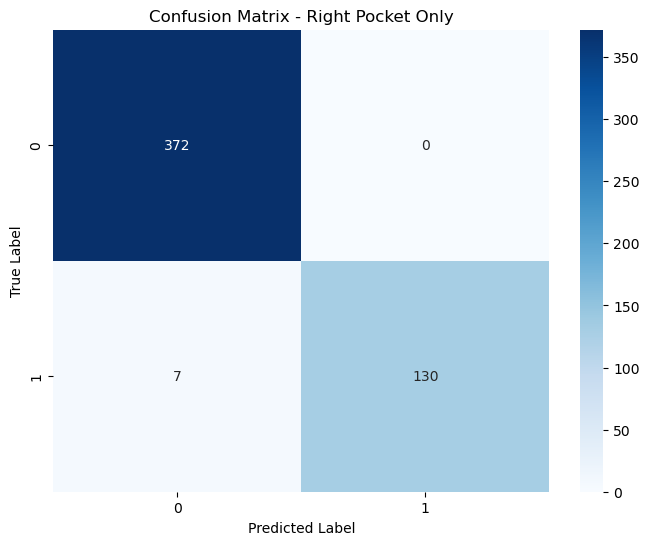

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os

warnings.filterwarnings('ignore')

def Window(data_frame, window_length, step_size):
    """
    This function segments the input time-series data into fixed-length windows.
    """
    # Calculate the number of samples (time steps) and channels (sensors) in the data
    num_samples = len(data_frame)
    num_channels = data_frame.shape[1] - 1  # Exclude the last column (assumed to be the label)

    # Calculate the number of windows that can be created
    num_windows = (num_samples - window_length) // step_size + 1

    # Initialize an array to store the windows
    windows = np.zeros((num_windows, window_length, num_channels))

    # Create windows by iterating over the data
    for i in range(num_windows):
        start_index = i * step_size
        end_index = start_index + window_length

        # Extract the window from the data (excluding the label column)
        windows[i] = data_frame.iloc[start_index:end_index, :-1].values

    return windows

class ComplexCNN1D(nn.Module):
    def __init__(self, input_shape):
        super(ComplexCNN1D, self).__init__()
        self.input_shape = input_shape

        # Initial Conv Layer
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=64, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.3)

        # First Residual Block
        self.conv2_shortcut = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1, padding='same')
        self.conv2_1 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.bn2_1 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        self.conv2_2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding='same')
        self.bn2_2 = nn.BatchNorm1d(128)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2)

        # Second Residual Block
        self.conv3_shortcut = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=1, padding='same')
        self.conv3_1 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding='same')
        self.bn3_1 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.4)
        self.conv3_2 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding='same')
        self.bn3_2 = nn.BatchNorm1d(256)
        self.maxpool3 = nn.MaxPool1d(kernel_size=2)

        # Third Residual Block
        self.conv4_shortcut = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=1, padding='same')
        self.conv4_1 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding='same')
        self.bn4_1 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.5)
        self.conv4_2 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, padding='same')
        self.bn4_2 = nn.BatchNorm1d(512)
        self.maxpool4 = nn.MaxPool1d(kernel_size=2)

        # Global Average Pooling and Fully Connected Layers
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(512, 1024)
        self.dropout5 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout6 = nn.Dropout(0.6)
        self.fc3 = nn.Linear(512, 1)

    def forward(self, x):
        # Initial Conv Layer
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        # First Residual Block
        shortcut = self.conv2_shortcut(x)
        x = F.relu(self.conv2_1(x))
        x = self.bn2_1(x)
        x = self.dropout2(x)
        x = F.relu(self.conv2_2(x))
        x = self.bn2_2(x)
        x = x + shortcut  # Residual connection
        x = self.maxpool2(x)

        # Second Residual Block
        shortcut = self.conv3_shortcut(x)
        x = F.relu(self.conv3_1(x))
        x = self.bn3_1(x)
        x = self.dropout3(x)
        x = F.relu(self.conv3_2(x))
        x = self.bn3_2(x)
        x = x + shortcut  # Residual connection
        x = self.maxpool3(x)

        # Third Residual Block
        shortcut = self.conv4_shortcut(x)
        x = F.relu(self.conv4_1(x))
        x = self.bn4_1(x)
        x = self.dropout4(x)
        x = F.relu(self.conv4_2(x))
        x = self.bn4_2(x)
        x = x + shortcut  # Residual connection
        x = self.maxpool4(x)

        # Global Average Pooling and Fully Connected Layers
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        x = torch.sigmoid(self.fc3(x))  # Sigmoid activation for binary classification

        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Training phase
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy
            predicted = (outputs >= 0.5).float()  # Convert probabilities to binary predictions
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                predicted = (outputs >= 0.5).float()  # Convert probabilities to binary predictions
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        # Calculate average losses and accuracy
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            #torch.save(model.state_dict(), 'right_pocket_model.pth')  # Save the best model
            model_dir = 'model'
            os.makedirs(model_dir, exist_ok=True)
            
            # Save the model state dict
            torch.save(model.state_dict(), os.path.join(model_dir, 'right_pocket_model.pth'))

            
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

def apply_threshold(predictions, threshold=0.5):
    return (predictions >= threshold).astype(int)

def predict(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in data_loader:
            outputs = model(inputs)  # Forward pass
            all_predictions.extend(outputs.cpu().numpy())  # Move predictions to CPU and convert to numpy
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy

    return np.array(all_predictions), np.array(all_labels)

print("Loading data...")
try:
    df = pd.read_csv('PreparedData.csv')
except FileNotFoundError:
    print("Error: PreparedData.csv not found.")
    raise Exception("Stopping cell early")


# Filter for Right Pocket sensors only
# Columns: rp_acc_x, rp_acc_y, rp_acc_z, rp_gyro_x, rp_gyro_y, rp_gyro_z, activity
print("Filtering for Right Pocket sensors...")
cols_to_keep = ['rp_acc_x', 'rp_acc_y', 'rp_acc_z', 'rp_gyro_x', 'rp_gyro_y', 'rp_gyro_z', 'activity']

# Verify columns exist
missing_cols = [col for col in cols_to_keep if col not in df.columns]
if missing_cols:
    print(f"Error: Missing columns in dataset: {missing_cols}")
    raise Exception("Stopping cell early")


df = df[cols_to_keep]

print(f"Data shape after filtering: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Create windows
print("Creating windows...")
x_zeros = Window(df[df['activity'] == 0] ,200 , 200)
y_zeros = np.zeros((x_zeros.shape[0]))

x_ones = Window(df[df['activity'] == 1] ,200 , 100)
y_ones = np.ones((x_ones.shape[0]))

x = np.concatenate((x_zeros, x_ones), axis=0)
y = np.concatenate((y_zeros, y_ones), axis=0)

print(f"Input shape: {x.shape}")

# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, shuffle=True , random_state=42, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32).permute(0, 2, 1)  # Permute dimensions
x_val = torch.tensor(x_val, dtype=torch.float32).permute(0, 2, 1)  # Permute dimensions
x_test = torch.tensor(x_test, dtype=torch.float32).permute(0, 2, 1)  # Permute dimensions

y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoaders
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model
input_shape = (200, 6) # 200 time steps, 6 channels
model = ComplexCNN1D(input_shape)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model
print("Starting training...")
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5)

# Evaluate model
print("Evaluating model...")
model.load_state_dict(torch.load('model/right_pocket_model.pth'))

y_train_pred, y_train_np = predict(model, train_loader)
y_test_pred, y_test_np = predict(model, test_loader)

y_train_pred_binary = apply_threshold(y_train_pred, threshold=0.5)
y_test_pred_binary = apply_threshold(y_test_pred, threshold=0.5)

print('Train Report', '\n', classification_report(y_train_np, y_train_pred_binary))
print('Test Report', '\n', classification_report(y_test_np, y_test_pred_binary))

print("Confusion Matrix (Test Set):")
cm = confusion_matrix(y_test_np, y_test_pred_binary)
print(cm)

# Save confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Right Pocket Only')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_right_pocket.png')
print("Confusion matrix plot saved to confusion_matrix_right_pocket.png")



## Model Check

In [2]:
!cd model && tar -czvf model.tar.gz right_pocket_model.pth


right_pocket_model.pth


Should result in "right_pocket_model.pth"

## Delete Old Endpoint config

In [3]:
import boto3

# Initialize SageMaker client
sm = boto3.client("sagemaker", region_name="ap-southeast-2")

# Name of your endpoint
ENDPOINT_NAME = "right-pocket-endpoint"

# Delete the endpoint
sm.delete_endpoint(EndpointName=ENDPOINT_NAME)
print(f"Deleted endpoint: {ENDPOINT_NAME}")

# Optional: delete the endpoint configuration as well
sm.delete_endpoint_config(EndpointConfigName='right-pocket-endpoint')
print("Deleted old endpoint configuration (if it existed).")



Deleted endpoint: right-pocket-endpoint
Deleted old endpoint configuration (if it existed).


## Deploy model on endpoint

In [4]:
import sagemaker
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role

role = get_execution_role()
sess = sagemaker.Session()

# Path to your model artifacts in S3
# First, upload your 'model' directory to S3
model_artifact = sess.upload_data(path='model/model.tar.gz', key_prefix='right-pocket-model')
print("S3 URI:", model_artifact)

pytorch_model = PyTorchModel(
    model_data=model_artifact,
    role=role,
    entry_point='inference.py',
    framework_version='2.0.0',
    py_version='py310'
)

predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge',  # bigger instance
    endpoint_name='right-pocket-endpoint'
)


print("Endpoint name:", predictor.endpoint_name)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
S3 URI: s3://sagemaker-ap-southeast-2-992382595357/right-pocket-model/model.tar.gz
-----!Endpoint name: right-pocket-endpoint


## System tests

### Evaluate trained model

In [5]:
model.eval()
dummy_input = torch.rand(1, 6, 200)  # batch, channels, timesteps
with torch.no_grad():
    output = model(dummy_input)
print(output)


tensor([[6.5795e-05]])
